Checking the label corresponding to the instance split ID after the data format conversion is complete

In [2]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = '../data/mydataset/train.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Category ID: 2, Category Name: tree
Category ID: 1, Category Name: canopy


## 云服务器上环境配置

In [ ]:
%pip install -U openmim
!mim install mmengine
!mim install "mmcv==2.1.0"
%pip install -v -e .

In [ ]:
!git clone https://github.com/YuDeng0102/Forestry-Remote-Sensing-Final-Assignmenterations.git


In [ ]:
!unzip ../../mydataset.zip -d .

## 下载预训练权重

In [1]:
# !mim download mmdet --config mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco --dest ./checkpoints
# !mim download mmdet --config cascade-mask-rcnn_r50-caffe_fpn_ms-3x_coco --dest ./checkpoints
!mim download mmdet --config mask2former_r50_8xb2-lsj-50e_coco --dest ./checkpoints


processing mask2former_r50_8xb2-lsj-50e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 MiB 12.1 MB/s eta 0:00:0000:0100:01
Successfully downloaded mask2former_r50_8xb2-lsj-50e_coco_20220506_191028-41b088b6.pth to /home/yudeng/code/deep-learning/mmdetection/myProject/checkpoints
Successfully dumped mask2former_r50_8xb2-lsj-50e_coco.py to /home/yudeng/code/deep-learning/mmdetection/myProject/checkpoints


## Maskrcnn

In [4]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask_rcnn/mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py')

In [8]:
from mmengine.runner import set_random_seed

# # Modify dataset classes and color
cfg.metainfo = {
    'classes': ('tree', 'canopy'),
    'palette': [
        (220, 20, 60),
        (40,120,180)
    ]
}

# Modify dataset type and path
cfg.data_root = './mydataset'

cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 2
cfg.model.roi_head.mask_head.num_classes = 2

# We can still the pre-trained Mask RCNN model to obtain a higher performance
#cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work-dir/mask-rcnn'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

max_epochs=30
cfg.train_cfg['max_epochs']=max_epochs
cfg.param_scheduler = [
    dict(
        begin=0, by_epoch=False, end=500, start_factor=0.001, type='LinearLR'),
    dict(
        begin=0,
        by_epoch=True,
        end=max_epochs,
        gamma=0.1,
        milestones=[
            15,
            25,
        ],
        type='MultiStepLR'),
]


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)


## seg batch_size
cfg.test_dataloader ['batch_size']=1
cfg.train_dataloader ['batch_size']=1
cfg.val_dataloader ['batch_size']=1





# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/mask-rcnn_r50.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

## mask2former

In [3]:
from mmengine import Config
cfg = Config.fromfile('../configs/mask2former/mask2former_r50_8xb2-lsj-50e_coco.py')

In [4]:
from mmengine.runner import set_random_seed

# # Modify dataset classes and color
cfg.metainfo = {
    'classes': ('tree', 'canopy'),
    'palette': [
        (220, 20, 60),
        (40,120,180)
    ]
}

# Modify dataset type and path
cfg.data_root = './mydataset'

cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.metainfo = cfg.metainfo
cfg.train_dataloader.dataset.data_prefix.img = 'train/'

cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.metainfo = cfg.metainfo
cfg.val_dataloader.dataset.data_prefix.img = 'val/'

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.panoptic_head['num_things_classes']=2
cfg.model.panoptic_head['num_stuff_classes']=0
cfg.model.panoptic_fusion_head['num_things_classes']=2
cfg.model.panoptic_fusion_head['num_stuff_classes']=0
cfg.model.panoptic_head.loss_cls['class_weight']=[1.0,1.0,0.1]


# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/myProject/checkpoints/mask2former_r50_8xb2-lsj-50e_coco_20220506_191028-41b088b6.pth'
cfg.load_from=None


# Set up working dir to save files and logs.
cfg.work_dir = './work-dir/mask2former'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)


## seg batch_size
cfg.test_dataloader ['batch_size']=1
cfg.train_dataloader ['batch_size']=1
cfg.val_dataloader ['batch_size']=1

# cfg.train_cfg['max_epochs']=40


# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/mask2former_r50.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### SOLO v2

In [17]:
from mmengine import Config
cfg = Config.fromfile('../configs/solov2/solov2_r50_fpn_ms-3x_coco.py')

In [18]:
from mmengine.runner import set_random_seed

# # Modify dataset classes and color
cfg.metainfo = {
    'classes': ('tree', 'canopy'),
    'palette': [
        (220, 20, 60),
        (40,120,180)
    ]
}

# Modify dataset type and path
cfg.data_root = './mydataset'

cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
cfg.model.mask_head.num_classes = 2


# We can still the pre-trained Mask RCNN model to obtain a higher performance
#cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work-dir/solov2'


# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.1 / 8
cfg.default_hooks.logger.interval = 10

param_scheduler = [
    dict(
        begin=0,
        by_epoch=False,
        end=500,
        start_factor=0.3333333333333333,
        type='LinearLR'),
    dict(
        begin=0,
        by_epoch=True,
        end=36,
        gamma=0.1,
        milestones=[
            27,
            33,
        ],
        type='MultiStepLR'),
]


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)


## seg batch_size
cfg.test_dataloader ['batch_size']=1
cfg.train_dataloader ['batch_size']=1
cfg.val_dataloader ['batch_size']=1

cfg.train_cfg['max_epochs']=30


# We can also use tensorboard to log the training process
# cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/solov2.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

## Train

In [19]:
# !python ../tools/train.py ./configs/mask-rcnn_r50.py
#!python ../tools/train.py ./configs/mask2former_r50.py
!python ../tools/train.py ./configs/solov2.py

12/14 15:00:26 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.20 (default, Oct  3 2024, 15:24:27) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2088530422
    GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
    CUDA_HOME: /usr/local/cuda-12.6
    NVCC: Cuda compilation tools, release 12.6, V12.6.85
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute

In [12]:
!python ../tools/test.py  ./configs/mask-rcnn_r50.py ./work-dir/mask-rcnn/epoch_3.pth

12/14 14:50:49 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.20 (default, Oct  3 2024, 15:24:27) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1353833314
    GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
    CUDA_HOME: /usr/local/cuda-12.6
    NVCC: Cuda compilation tools, release 12.6, V12.6.85
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute

## Test

In [13]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('mydataset/val/5d97350ae2b1f300057cb38a_4225.tif',channel_order='rgb')
checkpoint_file = 'work-dir/mask-rcnn/epoch_3.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: work-dir/mask-rcnn/epoch_3.pth
<DetDataSample(

    META INFORMATION
    pad_shape: (800, 800)
    img_shape: (800, 800)
    ori_shape: (2048, 2048)
    batch_input_shape: (800, 800)
    img_path: None
    scale_factor: (0.390625, 0.390625)
    img_id: 0

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9792, 0.9583, 0.9422, 0.9399, 0.9300, 0.9030, 0.8766, 0.8268, 0.8258,
                        0.8079, 0.7873, 0.7679, 0.7660, 0.7512, 0.7253, 0.7018, 0.7003, 0.6827,
                        0.6765, 0.6760, 0.6318, 0.6298, 0.5590, 0.5162, 0.5027, 0.4886, 0.4859,
                        0.4721, 0.4175, 0.3934, 0.3821, 0.3764, 0.3621, 0.3472, 0.3453, 0.3287,
                        0.3211, 0.3160, 0.3137, 0.3023, 0.2957, 0.2755, 0.2720, 0.2583, 0.2472,
                        0.2391, 0.2382, 0.2341, 0.2323, 0.2295, 0.2295, 0.2247, 0.2229, 0.216

/home/yudeng/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


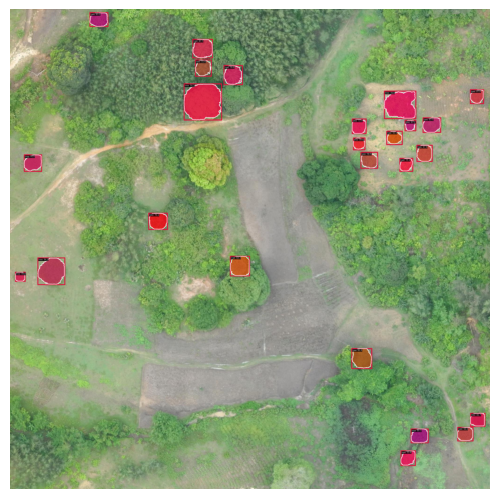

In [14]:
from mmdet.registry import VISUALIZERS
# get built visualizer
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta
# show the results
visualizer.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer.show()